 **PA005: High Value Customers Identification (Insiders)**

# IMPORTS

In [1]:
import re

import pandas as pd
import seaborn as sns
import numpy as np
import umap.umap_ as umap

from plotly              import express       as px 
from sklearn             import cluster       as c 
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble      as en
from matplotlib          import pyplot        as plt 
from sklearn.manifold    import TSNE
from sklearn             import manifold      as mn
from sklearn             import mixture       as mx
from sklearn.neighbors   import NearestNeighbors
from scipy.cluster       import hierarchy     as hc
        

/home/daniel/miniconda3/envs/ds_em_clusterizacao/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
path = '/home/daniel/repos/ds_em_clusterizacao/pa005_insiders_clustering/data/raw/ecommerce.csv'

df_raw = pd.read_csv (path)

## Data Cleaning

In [3]:
df = df_raw.copy()

df = df.drop(columns=['Unnamed: 8'], axis=1)

In [4]:

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <span style="color: OrangeRed;">DATA DESCRIPTION</span>
<span style="color: OrangeRed;">***PASSO 1***</span>

In [5]:
df1 = df.copy()

## Columns Description

|column|description|
|:-----|:---------|
|invoice_no|identificador de uma compra realizada no ecommerce|
|stock_code|identificador unico do produto comprado|
|description|descricao do produto|
|quantity|quantidade|
|invoice_date|data da compra|
|unit_price|preço unitario do produto|
|customer_id|identificador do comprador|
|country|pais do comprador|

## Rename Columns

In [6]:
new_columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = new_columns

## Data Dimensions

In [7]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of rows:{}'.format(df1.shape[1]))

Number of rows:541909
Number of rows:8


## Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [10]:
# === customer_id ===
# df1 = df1.dropna(subset=['customer_id'],axis=0)
# print('Removed data from subset customer_id: {:.2f}%'.format(100*(1-(df1.shape[0]/df_raw.shape[0]))))

# df separando missing e nao-missing
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
 
# selecionando invoice do missing no nao-missing, para encontrar correspondencia de customer_id
# df_not_missing.loc[df_not_missing['invoice_no'].isin(df_missing['invoice_no']), :] #Out: []

# Ultimo valor de de customer_id
# df1['customer_id'].max() #Out: 18287

# table of unique invoice that has customer_id missing
invoice_missing = pd.DataFrame(df_missing['invoice_no'].drop_duplicates()).reset_index(drop=True)

# Vector of values to assume sintetic 'customer_id' values
invoice_missing['customer_id'] = np.arange(19000, (19000 + len(invoice_missing)), 1)

# Merge to add sintetic values to orginal dataframe
df1 = pd.merge(df1, invoice_missing, on='invoice_no', how='left')

# Combine to aggregate into unique customer_id column
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

# ===description=== 
df1['description'] = df1['description'].fillna(0)

#Print missings 
df1.head()
print('\033[1mMissing values:\033[0m \n\n{}'.format(df1.isna().sum()))


Missing values: 

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64


## Change Dtypes

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [12]:
# invoice_date     
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.strftime('%Y-%m-%d')
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

# customer_id     
df1['customer_id'] = df1['customer_id'].astype(int)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [15]:
# Central Tendency - mean, median
c1 = pd.DataFrame(num_attributes.mean()).T
c2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame(num_attributes.min()).T
d2 = pd.DataFrame(num_attributes.max()).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.std())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

descriptive_analysis = pd.concat([ d1, d2, d3, c1, d4, c2, d5, d6], axis= 0).T.reset_index()
descriptive_analysis.columns = ['attributes','min','max', 'range','mean','std', 'median', 'skew', 'kurtosis']
descriptive_analysis

,attributes,min,max,range,mean,std,median,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,218.081158,3.00,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,96.759853,2.08,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,2911.411352,16249.00,0.487449,-0.804287


In [16]:
# unit_price with anomalous values 
print(df1.loc[df1['unit_price']<0.02].shape)

df1.loc[df1['unit_price']<0.02].sort_values('unit_price', ascending = True).head(10)

(2522, 8)


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499
290583,562386,84596L,0,-21,2017-08-02,0.00,United Kingdom,21453
285790,561924,22042,0,-197,2017-07-30,0.00,United Kingdom,21428
285886,561927,22740,?,-1060,2017-07-30,0.00,United Kingdom,21429
288156,562134,22722,0,1,2017-08-01,0.00,United Kingdom,21438
288157,562135,84847,0,1,2017-08-01,0.00,United Kingdom,21439
288519,562164,21257,?,-94,2017-08-01,0.00,United Kingdom,21440
288872,562212,21187,0,-97,2017-08-01,0.00,United Kingdom,21441
290639,562390,21246,0,-92,2017-08-02,0.00,United Kingdom,21454


### Categorical Attributes

In [17]:
cat_attributes.head()


,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Categorical attributes - Investigating

##### Invoice no

In [18]:
# problema: invoices com letras e numeros
# df1['invoice_no'].astype(int)

# identificacao:  counting anomalous invoice_no with a letter at beginning
contain_letter = df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x)))
unique_invoice_letter = df1.loc[contain_letter,'invoice_no']
print('invoice_no unicos que contem letras: {}'.format(unique_invoice_letter.drop_duplicates().count()))
print('invoice_no unicos: {}'.format(df1['invoice_no'].unique().shape[0]))
print('Linhas com invoices com letra no inicio: {}'.format(unique_invoice_letter.count()))
print('Linhas com quantidades < 0: {}'.format(df1.loc[df1['quantity']<0,'invoice_no'].count()))

invoice_no unicos que contem letras: 3839
invoice_no unicos: 25900
Linhas com invoices com letra no inicio: 9291
Linhas com quantidades < 0: 10624


In [19]:
unique_invoice_letter


141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: invoice_no, Length: 9291, dtype: object

##### Stock code

In [20]:
# stock_code that contain letter
contain_letter = df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x)))
unique_stock_letter = df1.loc[contain_letter,'stock_code'].drop_duplicates()
print('stock_code unicos com alguma letra: {}'.format(unique_stock_letter.count()))

# unique stock_code all letter
all_letters = df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x)))
unique_stock_all_letter = df1.loc[all_letters,'stock_code'].drop_duplicates()
print('stock_code que contem apenas letras: {}'.format(unique_stock_all_letter.count()))
print('stock code all letters: {}'.format(unique_stock_all_letter.unique()))

# identificação: linhas com stock_code somente letras 
df1.loc[df1['stock_code'].isin(unique_stock_all_letter)]

stock_code unicos com alguma letra: 1124


stock_code que contem apenas letras: 12
stock code all letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,2017-12-07,1714.17,United Kingdom,22709
541541,C581499,M,Manual,-1,2017-12-07,224.69,United Kingdom,15498
541730,581570,POST,POSTAGE,1,2017-12-07,18.00,Germany,12662
541767,581574,POST,POSTAGE,2,2017-12-07,18.00,Germany,12526


**Ação de limpeza:** dado que nao tenho conhecimento sobre esses valores com apenas letras, vou excluir nessa iteração

##### Description

In [21]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


**Ação:** enquanto nao sei como usar essa coluna para gerar alguma informação, vou exclui-la 

##### Country

In [22]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

Pontos que merecem atencao:<br>

- United Kingdom corresponde a quase todo dataset
- European Community aparece mesmo que os paises que se incluem nela aparecem separados 
- Unspecified

In [23]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [24]:
# customers per country
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id',ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# <span style="color: OrangeRed;">DATA FILTERING</span>
<span style="color: OrangeRed;">***PASSO 2*** </span>

In [25]:
df2 = df1.copy()

In [26]:
# === Categorical attributes === 
# stock_code
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS','B', 'CRUK'])]

# description
df2 = df2.drop(columns = ['description'], axis=1)

#country
df2 = df2.loc[~df2['country'].isin(['Unspecified','European Community']), :]

# bad customers
df2 = df2[~df2['customer_id'].isin([16446]) ]


# === Numerical attributes === 
# unit_price above 0.01
df2 = df2.loc[df2['unit_price']>0.01]

# quantity
df_returns = df2.loc[df2['quantity']<0]
df_purchase = df2.loc[df2['quantity']>0]





# <span style="color: OrangeRed;">FEATURE ENGINEERING</span>
<span style="color: OrangeRed;">***PASSO 3***</span>

In [27]:
df3 = df2.copy()

## Feature Creation

In [28]:
# dataframe of unique 'customer_id' to be merged with
df_customers = df2.drop(columns= ['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                                  'unit_price', 'country'],axis=1).drop_duplicates(ignore_index=True)

### Monetary - gross revenue by customers

In [29]:
# monetary or LTV - gross revenue/customer
df_purchase['gross_revenue'] = df_purchase['unit_price']*df_purchase['quantity']
df_monetary = df_purchase.groupby('customer_id')['gross_revenue'].sum().reset_index()
df_monetary = df_monetary.rename(columns = {'gross_revenue':'monetary'})

df_customers = pd.merge(df_customers,df_monetary, on='customer_id', how='left')
df_customers.isna().sum() # 91 linhas com quantity negativo 

/tmp/ipykernel_31530/3064971249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase['gross_revenue'] = df_purchase['unit_price']*df_purchase['quantity']


customer_id     0
monetary       91
dtype: int64

### Recency - days since last purchase

In [30]:
# recency - days since last purchase
df_recency = df_purchase.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency']]
df_recency.head()

df_customers = pd.merge(df_customers,df_recency, on='customer_id', how='left')
df_customers.head()
df_customers.isna().sum()

customer_id     0
monetary       91
recency        91
dtype: int64

### Frequency - purchases/day

In [31]:
# # frequency - purchases/month
# df_purchase['year_month'] = df_purchase['invoice_date'].dt.strftime('%Y-%m')
# df_frequency = df_purchase[['customer_id','year_month','invoice_no']].groupby(['customer_id','year_month']).nunique().reset_index()
# df_frequency = df_frequency.groupby('customer_id')['invoice_no'].mean().reset_index()
# df_frequency = df_frequency.rename (columns = {'invoice_no':'frequency'})
# df_frequency.head()

# df_customers = pd.merge(df_customers,df_frequency, on='customer_id', how='left')
# df_customers.head()
# df_customers.isna().sum()

In [32]:
# frequency - purchases/day
df_aux = (df_purchase[['invoice_no','customer_id','invoice_date']].drop_duplicates().groupby('customer_id')
                                                                           .aggregate (max_   = ('invoice_date','max'),
                                                                                       min_   = ('invoice_date','min'), 
                                                                                       period = ('invoice_date', lambda x: (x.max()-x.min()).days + 1),
                                                                                       invoice_no = ('invoice_no','count'))).reset_index()

df_aux['frequency'] = df_aux.apply(lambda x: x['invoice_no']/x['period'] if x['period']!=0 else 0, axis=1)

df_customers = pd.merge(df_customers, df_aux[['customer_id','frequency']], on='customer_id', how='left')
df_customers.isna().sum()

customer_id     0
monetary       91
recency        91
frequency      91
dtype: int64

### Quantity products - different stock_code by customer

In [33]:
df_products_purchased = df_purchase[['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'quantity_products'})
df_customers = pd.merge(df_customers,df_products_purchased, on='customer_id', how='left')
df_customers.isna().sum()

customer_id           0
monetary             91
recency              91
frequency            91
quantity_products    91
dtype: int64

### Returns - number of returns

In [34]:
df_returns[['customer_id','quantity']].drop_duplicates()

,customer_id,quantity
154,15311,-1
235,17548,-12
236,17548,-24
939,17897,-6
1441,17841,-1
...,...,...
540141,13599,-10
540176,17924,-4
540448,14397,-12
540449,14397,-11


In [35]:
# Number of returns 
df_returns = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity':'returns'})
df_returns['returns'] = df_returns['returns']*(-1)
df_customers = pd.merge(df_customers, df_returns,how='left',on='customer_id')
df_customers.loc[df_customers['returns'].isna(),'returns'] = 0
df_customers.isna().sum()

# first_purchase_at - min invoice_date

customer_id           0
monetary             91
recency              91
frequency            91
quantity_products    91
returns               0
dtype: int64

In [36]:
# path = '/home/daniel/repos/ds_em_clusterizacao/pa005_insiders_clustering/data/processed/'

# df_customers.to_csv(path+'feature_engineering.csv', index=False)

In [37]:
df_customers.shape

(5786, 6)

#  <span style="color: OrangeRed;">EXPLORATORY DATA ANALYSIS (EDA) PT1</span>
<span style="color: OrangeRed;">***PASSO 4*** </span>

In [38]:
#leitura do csv após feature engineering
# path = '/home/daniel/repos/ds_em_clusterizacao/pa005_insiders_clustering/data/processed/'
# df4 = pd.read_csv(path+'feature_engineering.csv')

In [39]:
# copy
df4 = df_customers.copy()
df4.head()

,customer_id,monetary,recency,frequency,quantity_products,returns
0,17850,5391.21,372.0,17.000000,297.0,21.0
1,13047,3232.59,56.0,0.028302,171.0,6.0
2,12583,6705.38,2.0,0.040323,232.0,50.0
3,13748,948.25,95.0,0.017921,28.0,0.0
4,15100,876.00,333.0,0.073171,3.0,22.0


In [40]:
# df4 = df_customers.dropna().copy() 
df4 = df4.dropna().copy() 
# exclusao dos 91 clientes que nao possuem nenhuma compra, e 3013 que só fizeram uma compra e, por isso, nao tem media de recencia


In [41]:
df4.shape

(5695, 6)

## Estudo do espaço 

In [42]:
# selected dataset without avg features
cols_selected = ['customer_id','monetary', 'recency', 'frequency', 'quantity_products', 'returns']
df43 = df4[cols_selected].drop(columns=['customer_id'], axis=1)

In [43]:
# MinMax Scaler
mm = pp.MinMaxScaler()

# Apply scalers
df43[['monetary' ]]              = mm.fit_transform(df43[['monetary' ]])
df43[['recency']]                = mm.fit_transform(df43[['recency']]) 
df43[['frequency']]              = mm.fit_transform(df43[['frequency']]) 
df43[['quantity_products']]      = mm.fit_transform(df43[['quantity_products']])
df43[['returns']]                = mm.fit_transform(df43[['returns']]) 

X = df43.copy()

In [44]:
df43.head()

,monetary,recency,frequency,quantity_products,returns
0,0.019312,0.997319,1.000000,0.037770,0.000283
1,0.011579,0.150134,0.001345,0.021692,0.000081
2,0.024020,0.005362,0.002052,0.029476,0.000674
3,0.003396,0.254692,0.000734,0.003445,0.000000
4,0.003137,0.892761,0.003985,0.000255,0.000296


### PCA


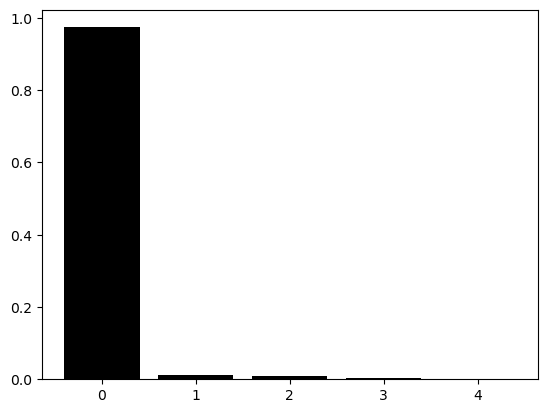

In [45]:
pca = dd.PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

# plot
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# to dataframe
df_pca = pd.DataFrame(principal_components)

In [46]:
# df_pca.shape

In [47]:
# plt.figure(figsize=(15,8))
# sns.scatterplot(x=0, y=1, data= df_pca)

### UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

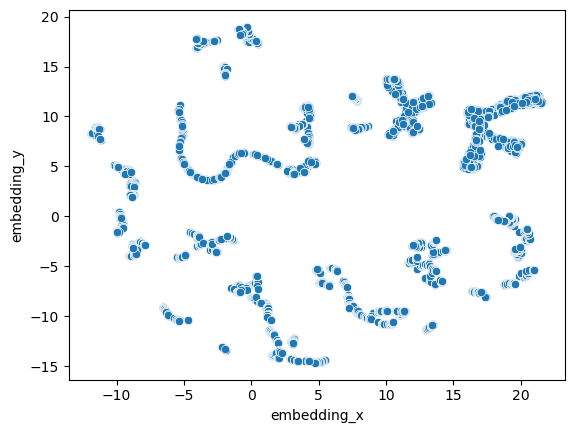

In [48]:
reducer = umap.UMAP (random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (X) #espaço projetado após reducao de dimensionalidade

#embedding
df_umap = pd.DataFrame()
df_umap ['embedding_x'] = embedding[:, 0]
df_umap ['embedding_y'] = embedding[:,1]

# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_umap)



### t-SNE


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

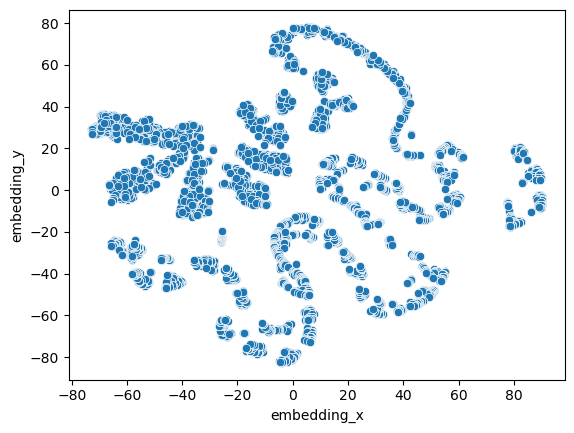

In [49]:
reducer = TSNE (n_components =2, 
                     n_jobs=-1,
                     random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (X) #espaço projetado após reducao de dimensionalidade

#embedding
df_tsne = pd.DataFrame()
df_tsne ['embedding_x'] = embedding[:, 0]
df_tsne ['embedding_y'] = embedding[:,1]

# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_tsne)


### Tree Based Embedding


In [50]:
# Training dataset
X = df43.drop(columns=['monetary'], axis=1)
y = df43['monetary']


# Model definition
rf_model = en.RandomForestRegressor(n_estimators = 1000, random_state=42)

# Model training
rf_model.fit (X, y)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))



In [51]:
# X.shape #Out: (2774, 100)
# df_leaf.shape. #Out:(2774, 10) 

/home/daniel/miniconda3/envs/ds_em_clusterizacao/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

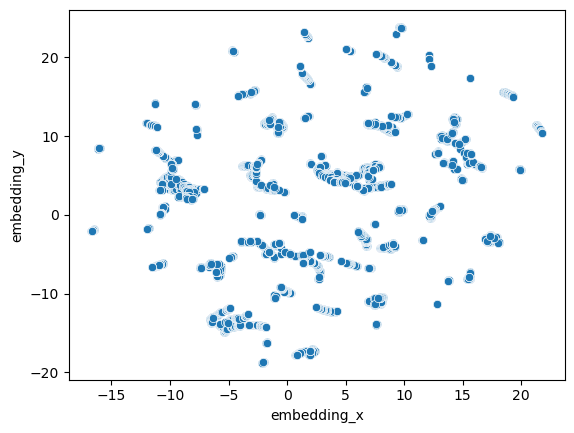

In [52]:
reducer = umap.UMAP (random_state=42) #n_neighbors quanto menor, ele foca mais nas estruturas locais em vez das globais
embedding = reducer.fit_transform (df_leaf) #espaço projetado após reducao de dimensionalidade

#embedding
df_tree = pd.DataFrame()
df_tree ['embedding_x'] = embedding[:, 0]
df_tree ['embedding_y'] = embedding[:,1]

# plot embeding
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data = df_tree)


# <span style="color: OrangeRed;">DATA PREPARATION</span>
<span style="color: OrangeRed;">***PASSO 5*** </span>

In [53]:
# Espaço de embedding - Tree Based
# df5 = df_tree.copy()

# UMAP embedding
df5 = df_umap.copy()
# df5.to_csv('../data/processed/umap_embedding.csv', index=False)

# # t-sne embedding
# df5 = df_tsne.copy() 


# <span style="color: OrangeRed;">HYPERPARAMETER FINE-TUNNING </span>
<span style="color: OrangeRed;">***PASSO 7***</span>

In [54]:
# Eapaço de embeding - Tree Based
X = df5.copy()

In [55]:
# clusters = [2, 3, 4, 5, 6, 7]
# List of clusters for embeding space 
clusters = np.arange(2, 26, 1)

## K-Means

In [56]:
kmeans_list = []
for k in  clusters:
    # model name
    kmeans_model = c.KMeans(n_init = 100,random_state=42, n_clusters = k )

    # model training
    kmeans_model.fit (X)

    # model predict
    labels = kmeans_model.predict(X)

    # perfomance
    sil_score = m.silhouette_score(X, labels, metric = 'euclidean')
    
    kmeans_list.append (sil_score)

Text(0, 0.5, 'Silhoette Score')

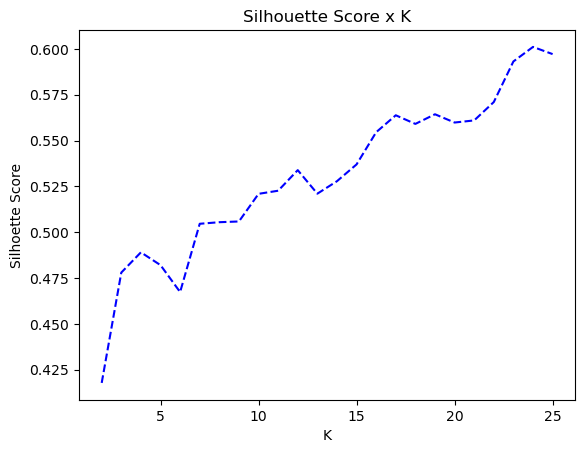

In [57]:
sns.lineplot(x = clusters, y = kmeans_list, markers='o', linestyle = '--', color = 'b' )
plt.title('Silhouette Score x K')
plt.xlabel ('K')
plt.ylabel ('Silhoette Score')

## Gaussian Mixture Models

In [58]:
gmm_list = []
for k in clusters:
    # model name
    gmm_model = mx.GaussianMixture (n_init = 10, random_state=42, n_components = k)
# 
    # model training
    gmm_model.fit(X)

    # predict
    labels_gmm = gmm_model.predict (X)

    # performance
    sil_score = m.silhouette_score(X, labels_gmm, metric='euclidean')
    
    gmm_list.append(sil_score)
    
    

Text(0, 0.5, 'Silhoette Score')

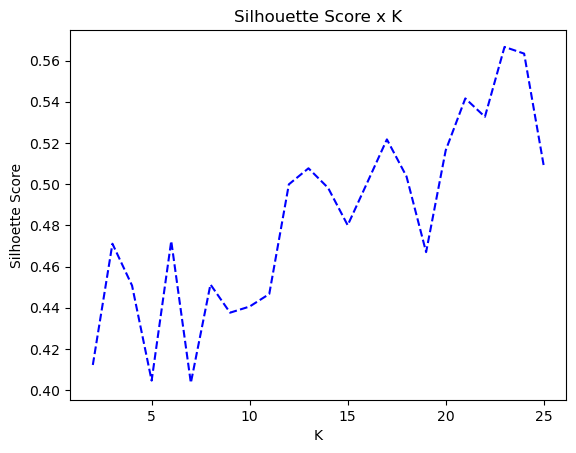

In [59]:
sns.lineplot(x= clusters, y = gmm_list, markers='o', linestyle = '--', color = 'b' )
plt.title('Silhouette Score x K')
plt.xlabel ('K')
plt.ylabel ('Silhoette Score')

## Hierarchical Clustering

In [60]:
hc_list =[]
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster (hc_model, k, criterion= 'maxclust') #se k é declarado, é necessario informar o criterio

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean') # após a definicao dos labels é feito o calculo da soma das silhuetas
    hc_list.append(sil)

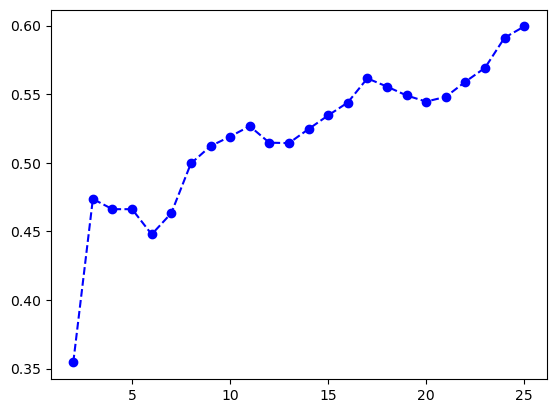

In [61]:
plt.plot(clusters, hc_list, marker='o', linestyle='--', color = 'b')

In [62]:
## Tree-based embedding - Results

# results = pd.DataFrame(
#     {'k-means': kmeans_list, 
#      'gmm'    : gmm_list, 
#      'hc'     : hc_list, 
#     }
# ).T

# results.columns = clusters
# results.style.highlight_max(color = 'lightgreen', axis=1)

In [63]:
## UMAP embedding - Results

# results = pd.DataFrame(
#     {'k-means': kmeans_list, 
#      'gmm'    : gmm_list, 
#      'hc'     : hc_list, 
#     }
# ).T

# results.columns = clusters
# results.style.highlight_max(color = 'lightgreen', axis=1)

In [64]:
## t-sne embedding - Results

results = pd.DataFrame(
    {'k-means': kmeans_list, 
     'gmm'    : gmm_list, 
     'hc'     : hc_list, 
    }
).T

results.columns = clusters
results.style.highlight_max(color = 'lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
k-means,0.417751,0.477959,0.489001,0.482013,0.467325,0.504576,0.505436,0.505834,0.520913,0.522606,0.533840,0.520998,0.527801,0.536965,0.554534,0.563773,0.559062,0.564324,0.559812,0.560965,0.570991,0.593129,0.601063,0.597145
gmm,0.412219,0.471080,0.450786,0.404616,0.472414,0.403499,0.451315,0.437601,0.440592,0.446663,0.499917,0.507704,0.498199,0.480058,0.500801,0.521731,0.503752,0.466997,0.516419,0.541618,0.532697,0.566630,0.563385,0.508955
hc,0.354396,0.473584,0.466133,0.466146,0.447782,0.463224,0.499471,0.512096,0.519100,0.526672,0.514613,0.514309,0.524532,0.534485,0.543872,0.561505,0.555517,0.549056,0.544567,0.548052,0.559047,0.569136,0.591128,0.599324


# <span style="color: OrangeRed;">MODEL TRAINING</span>
<span style="color: OrangeRed;">***PASSO 8***</span>

In [65]:
# Espaço de embedding RandomForest reduzida pelo UMAP
X.head()

,embedding_x,embedding_y
0,-0.339995,18.054976
1,4.394973,9.980254
2,18.354630,11.104085
3,2.711783,4.441715
4,-5.267880,11.119250


## K-Means

In [66]:
k = 8 
# Instancing the model 
kmeans = c.KMeans(init = 'random', n_clusters=k, n_init = 100, max_iter=300, random_state=42)

# Model Training
kmeans.fit(X)

# Labels
labels = kmeans.labels_

## Gaussian Mixture Model 

In [67]:
# # model name
# gmm_model = mx.GaussianMixture (n_components = k, random_state =10)

# # model training
# gmm_model.fit(X)

# # predict
# labels = gmm_model.predict (X)  
    

## Cluster validation

In [68]:
# WSS (Within-cluester Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

# Silhoute Score
print('Silhouette Score: {}'.format (m.silhouette_score (X, labels, metric = 'euclidean')))

WSS value: 74951.96875


Silhouette Score: 0.5053269267082214


# <span style="color: OrangeRed;">CLUSTER ANALYSIS</span>
<span style="color: OrangeRed;">***PASSO 9***</span>

In [69]:
# df9 = df6.drop(columns = ['customer_id']).copy()

# tabela de customers_ com label do cluster
df92 = df4.copy()
df92['labels'] = labels.tolist()
# df9 = df4.copy()
# df9['labels'] = labels.tolist()

# embedding com label do cluster
df9 = X.copy()
df9['labels'] = labels.tolist()


## Visualization Inspection

In [70]:
# fig = px.scatter_3d(df9, x='recency',y='frequency', z= 'monetary', color = 'labels')
# fig.show()
# Como a dimensionalidade esta >3 nao é possivel plotar os labels em torno dos eixos. 

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

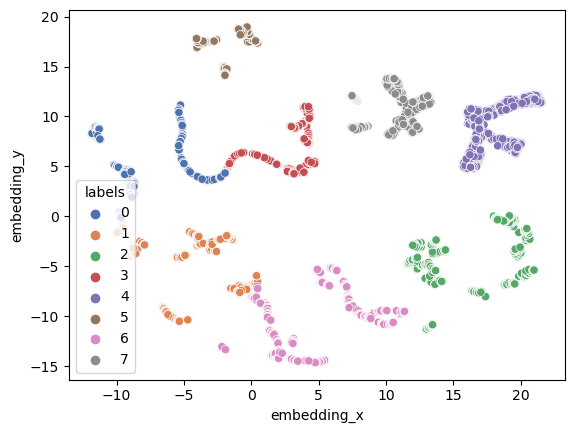

In [71]:
#ploting the embedding space + labels
sns.scatterplot (x = 'embedding_x', y = 'embedding_y', data = df9, hue = 'labels', palette = 'deep')

## Cluster Profile

In [72]:
# df_aux with the added labels to df6
# df_aux = df6.copy()
# df_aux['labels'] = labels.tolist()

df_aux = df92.copy()

In [73]:
# Number of customers
df_cluster = df_aux[['customer_id', 'labels']].groupby('labels').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100


# Avg Monetary
df_avg_monetary = df_aux[['monetary','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, how='inner', on = 'labels')


# Avg  Recency 
df_avg_recency = df_aux[['recency','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on = 'labels')


# Avg Frequency
df_avg_frequency = df_aux[['frequency','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on = 'labels')


# Quantity products
df_quantity_products = df_aux[['quantity_products','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_quantity_products, how='inner', on = 'labels')


# Returns
df_returns = df_aux[['returns','labels']].groupby('labels').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on = 'labels')

# Avg Ticket
# df_avg_ticket = df_aux[['labels','avg_ticket']].groupby('labels').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_ticket,how ='inner', on='labels')

# Avg Basket
# df_avg_basket = df_aux[['labels','avg_basket']].groupby('labels').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_basket,how ='inner', on='labels')

df_cluster

,labels,customer_id,perc_customer,monetary,recency,frequency,quantity_products,returns
0,0,621,10.904302,942.354235,261.793881,0.514264,57.592593,139.618357
1,1,607,10.658472,548.943789,252.369028,1.016474,44.573311,1.380560
2,2,885,15.539947,613.597864,41.358192,1.032647,41.232768,1.996610
3,3,598,10.500439,1360.935569,86.677258,0.028224,69.387960,7.132107
4,4,1099,19.297629,5053.862693,8.824386,0.045180,207.199272,49.464968
5,5,277,4.863916,906.624801,362.581227,1.051473,65.126354,1.649819
6,6,830,14.574188,667.164458,151.673494,1.019277,54.732530,0.780723
7,7,778,13.661106,1889.842211,33.012853,0.080740,122.654242,11.517995


### Cluster Profile 

In [74]:
df_cluster

,labels,customer_id,perc_customer,monetary,recency,frequency,quantity_products,returns
0,0,621,10.904302,942.354235,261.793881,0.514264,57.592593,139.618357
1,1,607,10.658472,548.943789,252.369028,1.016474,44.573311,1.380560
2,2,885,15.539947,613.597864,41.358192,1.032647,41.232768,1.996610
3,3,598,10.500439,1360.935569,86.677258,0.028224,69.387960,7.132107
4,4,1099,19.297629,5053.862693,8.824386,0.045180,207.199272,49.464968
5,5,277,4.863916,906.624801,362.581227,1.051473,65.126354,1.649819
6,6,830,14.574188,667.164458,151.673494,1.019277,54.732530,0.780723
7,7,778,13.661106,1889.842211,33.012853,0.080740,122.654242,11.517995


**Cluster 5 - Candidato a INSIDERS**
- Numero de customers: 355 (12.80%)
- Faturamento medio: $ 11,098
- Recencia media: 18 dias
- Media de produto: 485 produtos por compra
- Frequencia de compras por mes: 0.11 compras/dia
    
**Cluster 1 - ...**

#  <span style="color: OrangeRed;">EXPLORATORY DATA ANALYSIS (EDA) PT2</span>
<span style="color: OrangeRed;">***PASSO 10*** </span>

In [75]:
df10 = df92.copy()

In [76]:
df10.head()

,customer_id,monetary,recency,frequency,quantity_products,returns,labels
0,17850,5391.21,372.0,17.000000,297.0,21.0,5
1,13047,3232.59,56.0,0.028302,171.0,6.0,3
2,12583,6705.38,2.0,0.040323,232.0,50.0,4
3,13748,948.25,95.0,0.017921,28.0,0.0,3
4,15100,876.00,333.0,0.073171,3.0,22.0,0


# <span style="color: OrangeRed;">DEPLOY TO PRODUCTION </span>
<span style="color: OrangeRed;">***PASSO 11***</span>

In [77]:
#change dtypes
df10['recency'] = df10['recency'].astype(int)
df10['quantity_products'] = df10['quantity_products'].astype(int)
df10['returns'] = df10['returns'].astype(int)

In [78]:
import sqlalchemy 
import sqlite3
from sqlalchemy import text

In [79]:
# Drop table
# query_drop_table = """
#     drop table insiders 
# """
# conn = sqlite3.connect ('../data/insiders_db.sqlite')
# conn.execute(query_drop_table)

# database connection
# conn = sqlite3.connect ('../data/insiders_db.sqlite')
# conn = sqlalchemy.create_engine('sqlite:///../data/insiders_db.sqlite')

engine = sqlalchemy.create_engine('sqlite:///src/data/insiders_db.sqlite')

# create table 
query_create_table_insiders = """
    CREATE TABLE insiders (
       customer_id            INTEGER,
       monetary               REAL,
       recency                INTEGER,
       frequency              REAL,
       quantity_products      INTEGER,
       returns                INTEGER,
       labels                 INTEGER 
    )
"""

with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(query_create_table_insiders))         
# df = pd.DataFrame(query.fetchall())

# conn.execute(query_create_table_insiders)

In [80]:
# insert data
# conn = create_engine('sqlite:///../src/data/insiders_db.sqlite')
# conn = sqlalchemy.create_engine('sqlite:///insiders_db.sqlite')
with engine.connect().execution_options(autocommit=True) as conn:
    df92.to_sql('insiders', con = conn, if_exists = 'append', index=False)

In [81]:
# get query 
# query_collect = """
#     select * from insiders
# """
# # database connection
# conn = sqlite3.connect ('../data/insiders_db.sqlite')

# read sql
# df = pd.read_sql_query(query_collect,conn)
# df.head()

In [82]:
# engine = sqlalchemy.create_engine('sqlite:///../data/insiders_db.sqlite')

In [83]:
# conn = create_engine('sqlite:///../data/insiders_db.sqlite').connect()
# conn = engine.connect()
# df = pd.read_sql_query(query_collect,conn)
# df.head()

In [84]:
# from sqlalchemy.sql import text
# sql = '''
#     SELECT * FROM insiders;
# '''
# with engine.connect().execution_options(autocommit=True) as conn:
#     query = conn.execute(text(sql))         
# df = pd.DataFrame(query.fetchall())

In [85]:
# engine.connect()

In [86]:
# df.head()